In [2]:
from libraries.DES import *
from libraries.theoretical_results import *
import matplotlib.pyplot as plt
import numpy as np

In [62]:
def run_simulations(rho_steps, num_samples, num_servers, policy,queuetype="MM",rho_range=(0.1,1),mu=1):
    """Runs the simulation for a given number of steps and samples

    Args:
        steps (int): Number of steps
        num_samples (int): Number of samples
        num_servers (int): Number of servers
        policy (str): Scheduling policy
        queuetype (str, optional): Type of queue. Defaults to "MM". Options are "MM", "MD", "MC".

    Returns:
        list: Average wait times
        list: Standard deviations
        list: System loads
        list: Service rates
        list: Arrival rates
    """
    # Initialize lists
    rho_list = []
    mu_list = []
    lamda_list = []
    averages_of_average_wait_times = []
    std_devs = []

    for rho in np.linspace(rho_range[0],rho_range[1], rho_steps):
        # Calculate lambda
        mu = mu
        lamda = rho * mu * num_servers
        # Run simulation for num_samples
        average_wait_times = []
        until = average_waiting_time_mmn(lamda,mu,num_servers)
        for _ in range(num_samples):
            wait_times = []
            env = simpy.Environment()
            env.process(run_server(env, num_servers, lamda, mu, wait_times, policy,queuetype=queuetype))
            env.run(until=min(until*200,20000))
            average_wait = get_average_wait_time(wait_times[-80:])
            average_wait_times.append(average_wait)
        # Append results to lists
        rho_list.append(rho)
        mu_list.append(mu)
        lamda_list.append(lamda)
        
        averages_of_average_wait_times.append(statistics.mean(average_wait_times))
        std_devs.append(np.std(average_wait_times))
    
    return averages_of_average_wait_times, std_devs, rho_list, mu_list, lamda_list

# 2) Write a DES program to verify the theoretical results with simulations for n=1,n=2,n=4.

Below we plot the results for n=1, n=2 and n=4. We compare them to the theoretical result for values of $\rho$ ranging from 0.85 to 0.999.


In [63]:
rho_range = (.9,.999)
num_rho_steps = 10
num_sims=60
full_data = []
for n,rho_range in zip([1,2,4],[rho_range,(.95,.999),(.95,.999)]):
    data = run_simulations(num_rho_steps,num_sims,n,"FIFO",rho_range=rho_range)
    full_data.append(data)

In [72]:
def plot_compare_theory_vs_sim(n,rho_range,data):
    """Plots the theoretical results against the simulation results
    """
    averages_of_average_wait_times, std, rho_list, mu_list, lamda_list = data
    exact_rhos = np.linspace(rho_range[0], rho_range[1],500)
    exact_wait_times = average_waiting_time_mmn(exact_rhos*n,1,n)
    plt.title(f'Average waiting time for M/M/{n} queue compared with simulation')
    plt.errorbar(rho_list, averages_of_average_wait_times, yerr=std/np.sqrt(num_sims), fmt="o",label='Simulation and SEM')
    plt.plot(exact_rhos,exact_wait_times+1 ,label='theoretical')
    plt.xlabel(r'$\rho$ (system load)')
    plt.ylabel('Average waiting time (arbitrary units)')
    #plt.ylim(-1,max(averages_of_average_wait_times)+max(std/np.sqrt(num_sims))+5)
    plt.legend()
    plt.show()

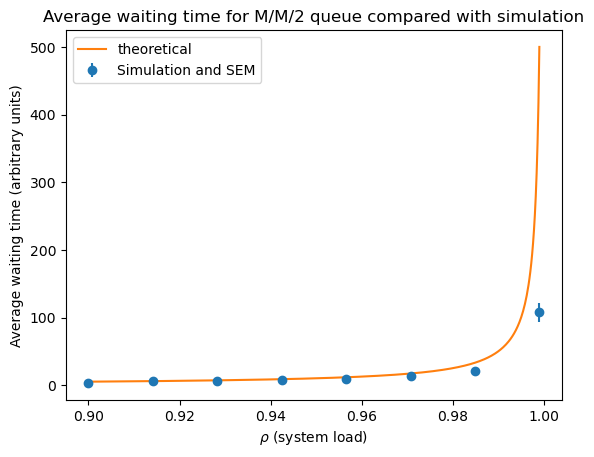

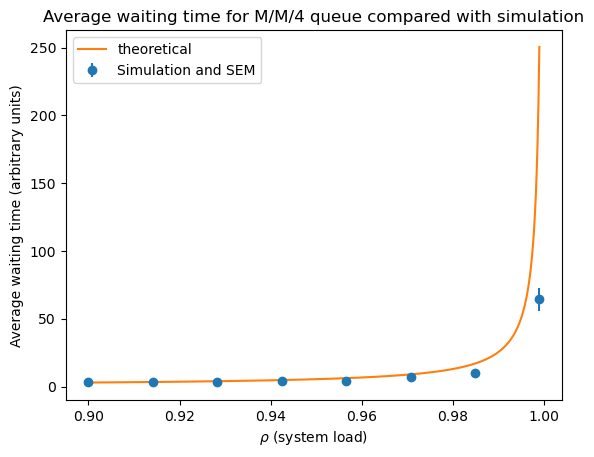

In [73]:
for i,n in enumerate([1,2,4]):
    plot_compare_theory_vs_sim(n,rho_range, data = full_data[i])

# 3) Compare the results to that for an M/M/1 queue with SJF.

In the next part we compare SJF to FIFO